In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load all three JSON files
with open('/home/sancho/Documents/FRI/Year 2/Big Data/bd-project-25/data/ride_counts/yellow_ride_count.json') as f:
    yellow_data = json.load(f)

with open('/home/sancho/Documents/FRI/Year 2/Big Data/bd-project-25/data/ride_counts/green_ride_counts.json') as f:
    green_data = json.load(f)

with open('/home/sancho/Documents/FRI/Year 2/Big Data/bd-project-25/data/ride_counts/fhvhv_monthly_rides_by_company.json') as f:
    fhvhv_data = json.load(f)

# Flatten yellow and green datasets
def flatten_service_data(data, service_name):
    rows = []
    for year, months in data.items():
        for month, count in months.items():
            rows.append({
                "year": int(year),
                "month": int(month),
                "operator": service_name,
                "trips": int(count)
            })
    return pd.DataFrame(rows)

df_yellow = flatten_service_data(yellow_data, "Yellow Taxi")
df_green = flatten_service_data(green_data, "Green Taxi")

# Flatten FHVHV data
COMPANY_MAP = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

fhvhv_rows = []
for year, company_data in fhvhv_data.items():
    for company_id, month_counts in company_data.items():
        for month, count in month_counts.items():
            operator = COMPANY_MAP.get(company_id, "Other FHVHV")
            fhvhv_rows.append({
                "year": int(year),
                "month": int(month),
                "operator": operator,
                "trips": int(count)
            })

df_fhvhv = pd.DataFrame(fhvhv_rows)

# Combine all into one DataFrame
df_all = pd.concat([df_yellow, df_green, df_fhvhv], ignore_index=True)

# Add datetime for easier plotting
df_all['date'] = pd.to_datetime(dict(year=df_all.year, month=df_all.month, day=1))

# Compute relative share
monthly_totals = df_all.groupby('date')['trips'].sum().reset_index(name='total_trips')
df_all = df_all.merge(monthly_totals, on='date')
df_all['share'] = df_all['trips'] / df_all['total_trips']

# Sort for plotting
df_all = df_all.sort_values("date")


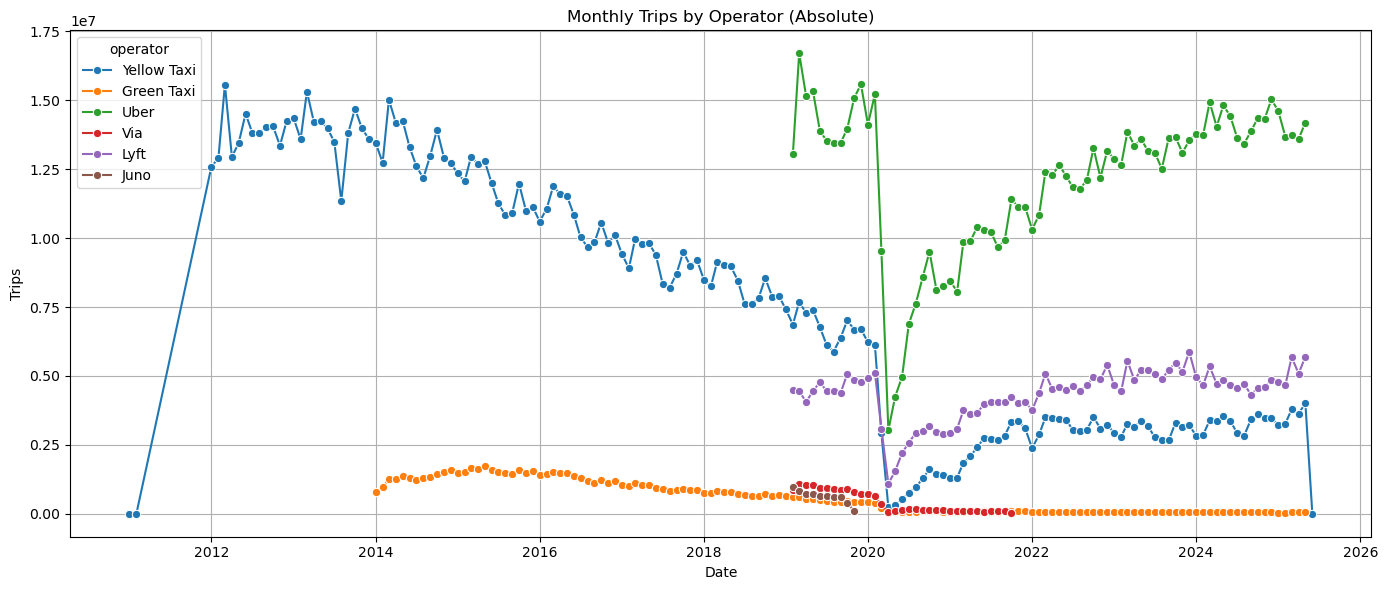

In [20]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_all, x='date', y='trips', hue='operator', marker='o')
plt.title("Monthly Trips by Operator (Absolute)")
plt.ylabel("Trips")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


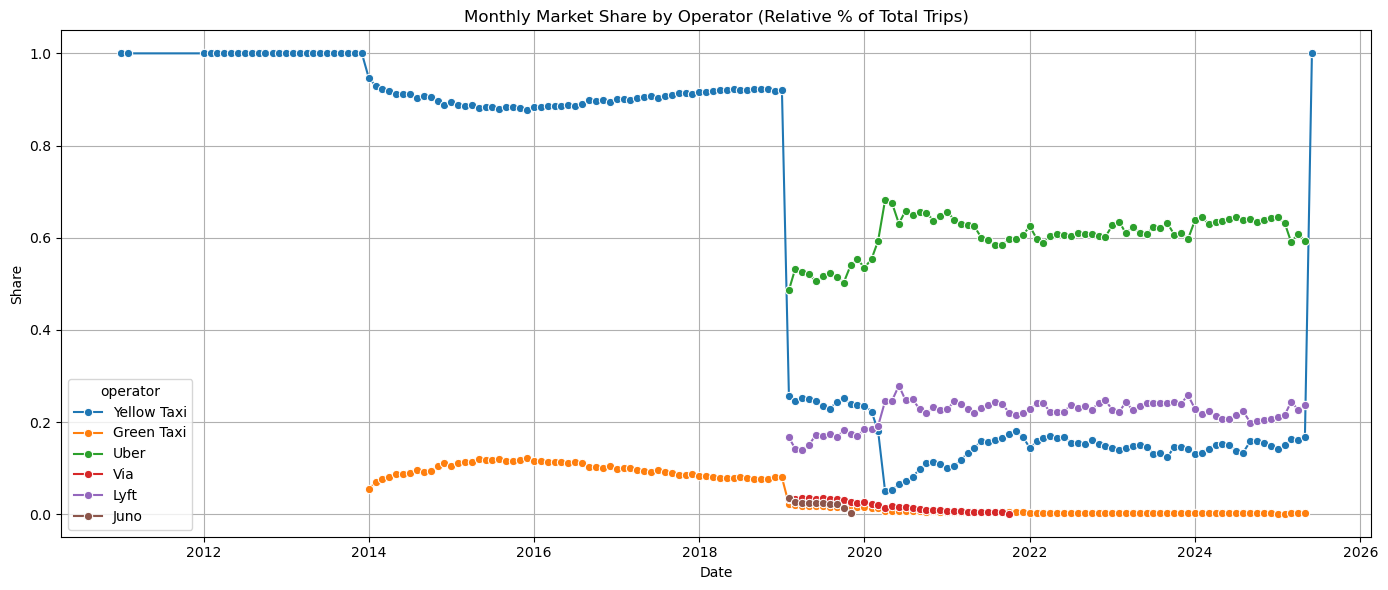

In [21]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_all, x='date', y='share', hue='operator', marker='o')
plt.title("Monthly Market Share by Operator (Relative % of Total Trips)")
plt.ylabel("Share")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

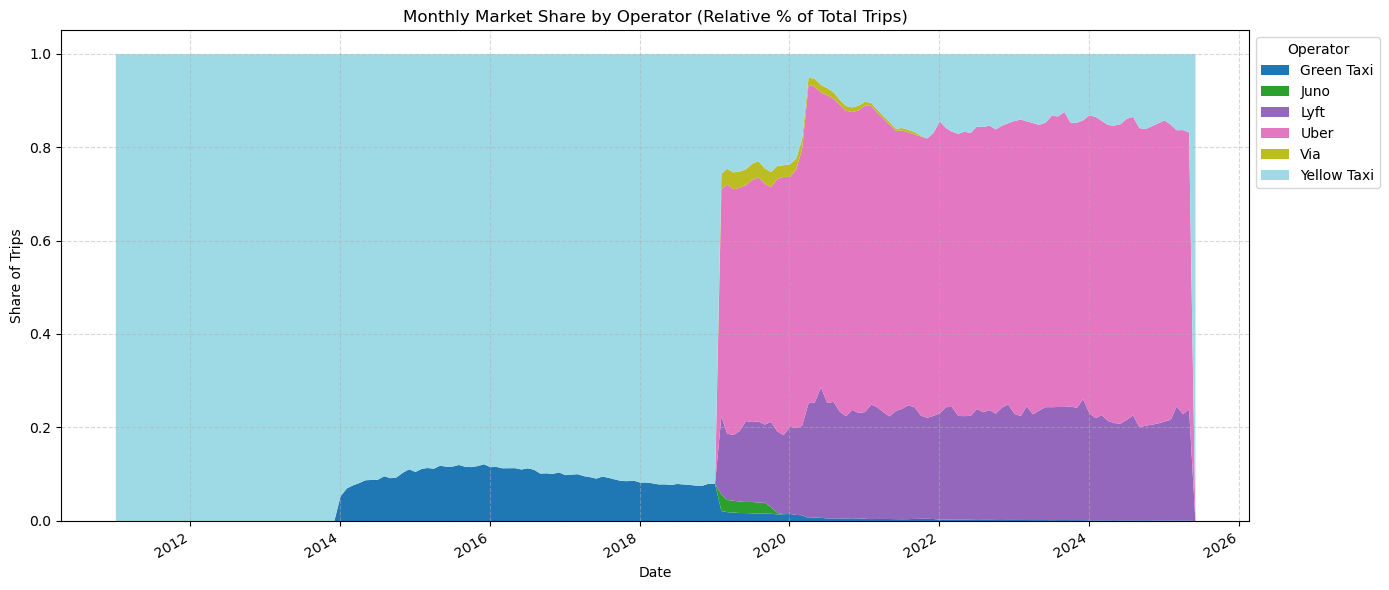

In [24]:
# Prepare the data: pivot to get operators as columns, fill missing months with 0
share_pivot = df_all.pivot_table(index='date', columns='operator', values='share', fill_value=0)

# Sort columns for consistent color order (optional)
share_pivot = share_pivot[sorted(share_pivot.columns)]

# Plot
plt.figure(figsize=(14, 6))
share_pivot.plot.area(stacked=True, figsize=(14, 6), cmap="tab20", linewidth=0)

plt.title("Monthly Market Share by Operator (Relative % of Total Trips)")
plt.ylabel("Share of Trips")
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Operator", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
